In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

from PopSynthesis.Methods.connect_HH_PP.paras_dir import processed_data, output_dir, data_dir

In [2]:
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

geo_lev = "POA"

In [3]:
syn_hh_ipu = pd.read_csv(os.path.join(output_dir, "new_test","syn_hh_ipu.csv"))
syn_pp_ipu = pd.read_csv(os.path.join(output_dir, "new_test","syn_pp_ipu.csv"))
syn_hh_ipu = syn_hh_ipu.drop(columns=["serialno", "cat_id", "sample_geog"])
syn_hh_ipu = syn_hh_ipu.rename(columns={"geog": "POA"})
syn_hh_ipu["hhid"] = syn_hh_ipu.index
syn_pp_ipu = syn_pp_ipu.drop(columns=["serialno", "cat_id", "sample_geog"])
syn_pp_ipu = syn_pp_ipu.rename(columns={"household_id": "hhid", "geog": "POA"})

In [4]:
syn_hh_adjust = pd.read_csv(os.path.join(output_dir,"new_test", f"syn_hh_final_POA_ad5.csv"))
syn_pp_adjust = pd.read_csv(os.path.join(output_dir,"new_test", f"syn_pp_final_POA_ad5.csv"))

In [5]:
syn_hh_noad = pd.read_csv(os.path.join(output_dir,"new_test", f"hh_no_adjustments.csv"))
syn_pp_noad = pd.read_csv(os.path.join(output_dir,"new_test", f"pp_no_adjustments.csv"))

In [6]:
# dict_hhid = dict(zip(syn_hh_adjust["hhid"], syn_hh_adjust[geo_lev]))
# syn_pp_adjust[geo_lev] = syn_pp_adjust.apply(lambda r: dict_hhid[int(r["hhid"])],axis=1)
syn_pp_adjust

,hhid,age,sex,persinc,nolicence,anywork,POA,relationship
0,1,50-59,F,$800-999 p.w.,No Licence,N,3000,Main
1,38,50-59,M,$2000+ p.w.,Some Licence,Y,3000,Main
2,45,70-79,F,$1000-1249 p.w.,No Licence,N,3000,Main
3,75,50-59,F,$800-999 p.w.,No Licence,N,3000,Main
4,92,50-59,F,$1-199 p.w.,No Licence,N,3000,Main
...,...,...,...,...,...,...,...,...
6373352,2859545,60-69,F,Zero Income,Some Licence,N,3283,Others
6373353,2835981,40-49,F,Negative Income,Some Licence,N,3238,Others
6373354,2835981,30-39,F,$1000-1249 p.w.,Some Licence,Y,3238,Others
6373355,2839452,40-49,M,$400-599 p.w.,Some Licence,N,3190,Others


In [7]:
syn_hh_adjust = syn_hh_adjust.drop(columns=["Spouse", "Child", "Others", "Grandchild"])
syn_hh_adjust

,dwelltype,owndwell,hhinc,totalvehs,hhsize,POA,hhid
0,Terrace/Townhouse,Something Else,Nil income,3,5,3583,2334366
1,Flat or Apartment,Being Purchased,1-149,0,1,3000,1162271
2,Flat or Apartment,Being Purchased,1-149,0,1,3000,1163023
3,Flat or Apartment,Being Purchased,1-149,0,1,3000,1163137
4,Flat or Apartment,Being Purchased,1-149,0,1,3000,1163284
...,...,...,...,...,...,...,...
2420216,Separate House,Something Else,400-499,2,1,3996,2864678
2420217,Separate House,Something Else,800-999,2,1,3996,2864679
2420218,Other,Being Purchased,500-649,2,1,3996,2864680
2420219,Terrace/Townhouse,Being Purchased,Nil income,2,1,3996,2864681


In [8]:
ls_atts_hh = [x for x in syn_hh_adjust.columns if x not in ["relationship", "POA", "hhid"]]
atts_hh_labels = {att: list(syn_hh_adjust[att].unique()) for att in ls_atts_hh}
atts_hh_labels["totalvehs"] = ['0', '1', '2', '3', '4+']
atts_hh_labels["hhsize"] = ['1', '2', '3', '4', '5', '6', '7', '8+']
atts_hh_labels["hhinc"] = [
'Negative income',
'Nil income',
  '1-149',
  '150-299',
  '300-399',
  '400-499',
  '500-649',
  '650-799',
  '800-999',
  '1000-1249',
  '1250-1499',
  '1500-1749',
  '1750-1999',
  '2000-2499',
  '2500-2999',
  '3000-3499',
  '3500-3999',
  '4000-4499',
  '4500-4999',
  '5000-5999',
  '6000-7999',
  '8000+',
]
atts_hh_labels

{'dwelltype': ['Terrace/Townhouse',
  'Flat or Apartment',
  'Missing',
  'Other',
  'Separate House'],
 'owndwell': ['Something Else',
  'Being Purchased',
  'Being Rented',
  'Fully Owned'],
 'hhinc': ['Negative income',
  'Nil income',
  '1-149',
  '150-299',
  '300-399',
  '400-499',
  '500-649',
  '650-799',
  '800-999',
  '1000-1249',
  '1250-1499',
  '1500-1749',
  '1750-1999',
  '2000-2499',
  '2500-2999',
  '3000-3499',
  '3500-3999',
  '4000-4499',
  '4500-4999',
  '5000-5999',
  '6000-7999',
  '8000+'],
 'totalvehs': ['0', '1', '2', '3', '4+'],
 'hhsize': ['1', '2', '3', '4', '5', '6', '7', '8+']}

In [9]:
ls_atts_pp = [x for x in syn_pp_adjust.columns if x not in ["relationship", "POA", "hhid", "nolicence"]]
atts_pp_labels = {att: list(syn_pp_adjust[att].unique()) for att in ls_atts_pp}
# But this is not sorted
atts_pp_labels["age"] = [
    '0-9', 
    '10-19', 
    '20-29', 
    '30-39', 
    '40-49', 
    '50-59', 
    '60-69',
    '70-79',
    '70-79',
    '80-89',
    '90-99',
    "100+"
]

atts_pp_labels ["persinc"] = [
    "Missing/Refused",
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]
atts_pp_labels

{'age': ['0-9',
  '10-19',
  '20-29',
  '30-39',
  '40-49',
  '50-59',
  '60-69',
  '70-79',
  '70-79',
  '80-89',
  '90-99',
  '100+'],
 'sex': ['F', 'M'],
 'persinc': ['Missing/Refused',
  'Negative Income',
  'Zero Income',
  '$1-199 p.w.',
  '$200-299 p.w.',
  '$300-399 p.w.',
  '$400-599 p.w.',
  '$600-799 p.w.',
  '$800-999 p.w.',
  '$1000-1249 p.w.',
  '$1250-1499 p.w.',
  '$1500-1999 p.w.',
  '$2000+ p.w.'],
 'anywork': ['N', 'Y']}

In [10]:
def plot_bar_syn(att, att_lab, rela=None, is_hh=True):
    if rela is not None:
        df_ipu = syn_pp_ipu[syn_pp_ipu["relationship"] == rela]
        df_adjust = syn_pp_adjust[syn_pp_adjust["relationship"] == rela]
        df_noad = syn_pp_noad[syn_pp_noad["relationship"] == rela]
    elif is_hh:
        df_ipu = syn_hh_ipu
        df_adjust = syn_hh_adjust
        df_noad = syn_hh_noad
    else:
        df_ipu = syn_pp_ipu
        df_adjust = syn_pp_adjust
        df_noad = syn_pp_noad

    n_ipu = len(df_ipu) 
    counts_ipu = df_ipu[att].value_counts()

    n_adjust = len(df_adjust) 
    counts_adjust = df_adjust[att].value_counts()

    n_noad = len(df_noad) 
    counts_noad = df_noad[att].value_counts()

    data_ipu = []
    data_adjust = []
    data_noad = []
    data_sample = []

    if rela is not None:
        if rela != "Main":
            df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_main_{rela}.csv"))
            sub_df_sample = df_rela_sample[f"{att}_{rela}"].value_counts()
        else:
            df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_hh_main.csv"))
            sub_df_sample = df_rela_sample[att].value_counts()
        n_sample = len(df_rela_sample)
        sub_df_sample = sub_df_sample / n_sample
    else:
        if is_hh:
            df_sample = pd.read_csv(os.path.join(processed_data, f"ori_sample_hh.csv"))
        else:
            df_sample = pd.read_csv(os.path.join(processed_data, f"ori_sample_pp.csv"))
        sub_df_sample = df_sample[att].value_counts()
        n_sample = len(df_sample)
        sub_df_sample = sub_df_sample / n_sample

    for state in att_lab[att]:
        if state in counts_ipu.index:
            data_ipu.append((counts_ipu.at[state]/n_ipu)*100) 
        else:
            data_ipu.append(0) 

        if state in counts_adjust.index:
            data_adjust.append((counts_adjust.at[state]/n_adjust)*100) 
        else:
            data_adjust.append(0)

        if state in counts_noad.index:
            data_noad.append((counts_noad.at[state]/n_noad)*100) 
        else:
            data_noad.append(0)

        if state in sub_df_sample.index:
            data_sample.append((sub_df_sample[state])*100)
        else:
            data_sample.append(0)

    X = att_lab[att]
    X_axis = np.arange(len(X))
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(X_axis - 0.25, data_ipu, 0.1, label = 'IPU') 
    plt.bar(X_axis - 0.15, data_adjust, 0.1, label = 'IPSF')
    plt.bar(X_axis - 0.05, data_adjust, 0.1, label = 'BN & CSP')
    plt.bar(X_axis + 0.1, data_sample, 0.2, label = 'VISTA') 
    if rela is not None:
        plt.title(f"{att} for {rela}")
        # plt.xlabel(f"States")
        plt.ylabel(f"% of the {rela} population")
    else:
        plt.title(f"{att}")
        # plt.xlabel(f"States")
        plt.ylabel(f"% of the whole population")
    
    plt.xticks(X_axis, X, rotation=90)
    plt.legend()
    plt.tight_layout()
    if rela is not None:
        plt.savefig(f"./output/imgs/samples/{rela}_{att}_samples_compa")
    else:
        plt.savefig(f"./output/imgs/samples/hh{is_hh}_{att}_samples_compa")
    return {
        "vista": data_sample,
        "ipu": data_ipu,
        "simplebn": data_noad, 
        "adjust": data_adjust,
        "states": list(att_lab[att])
    }

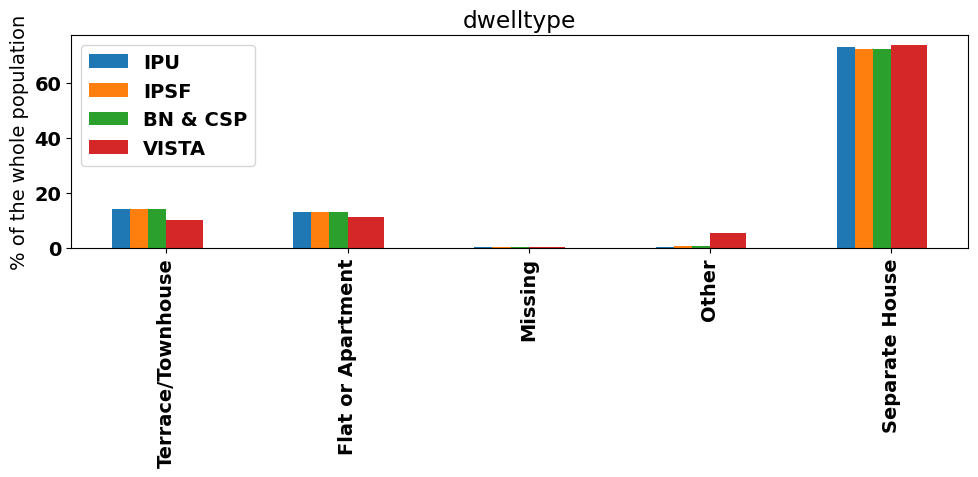

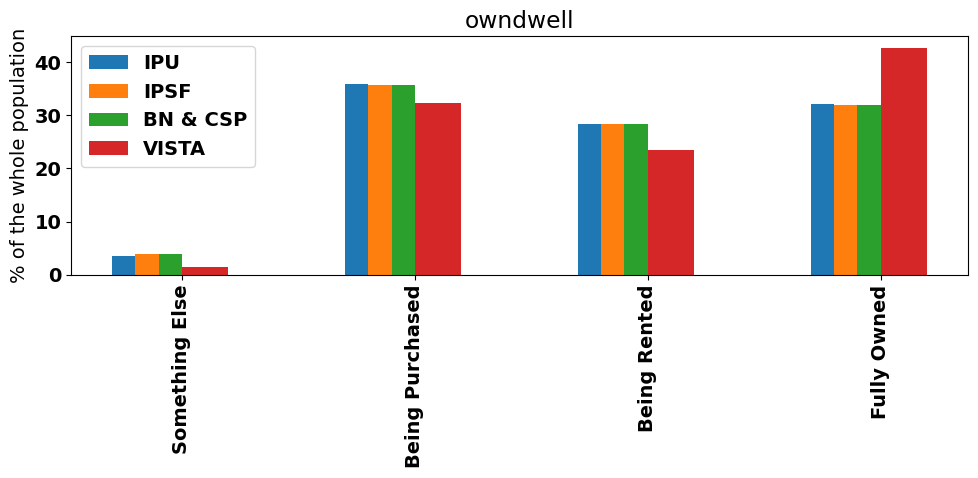

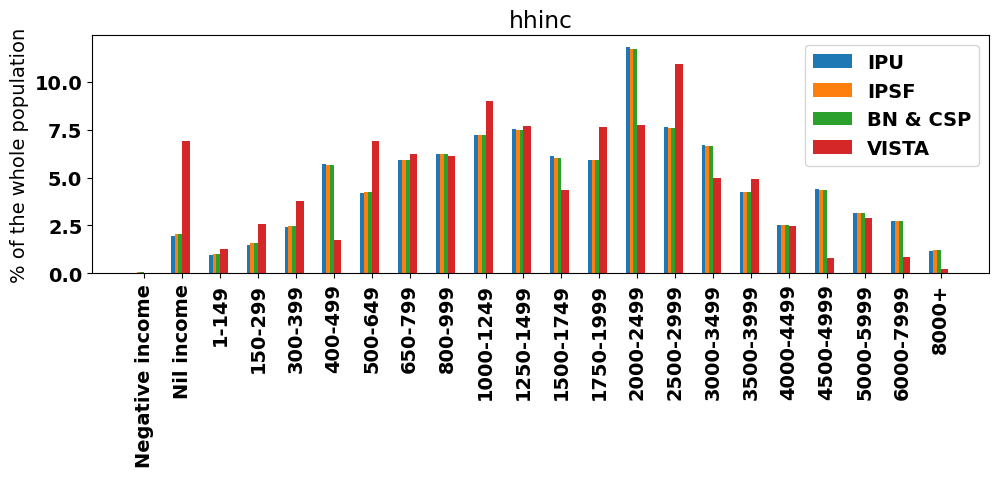

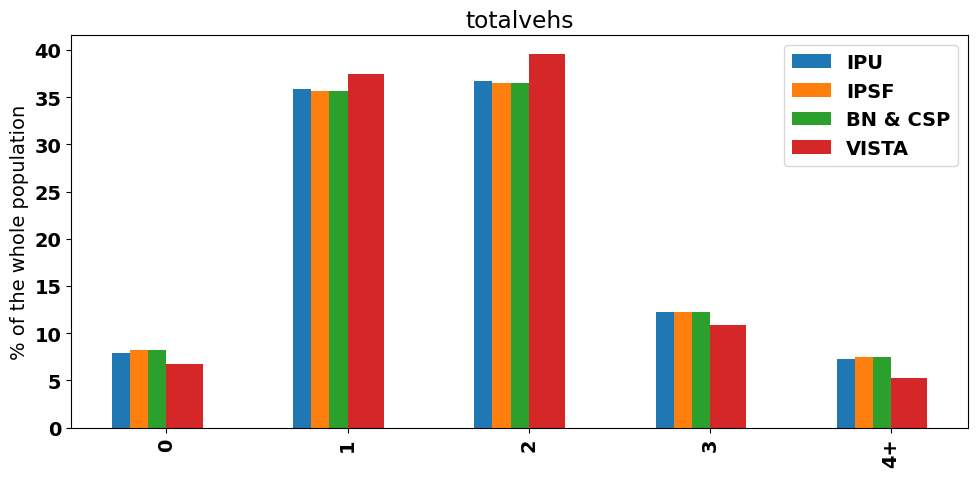

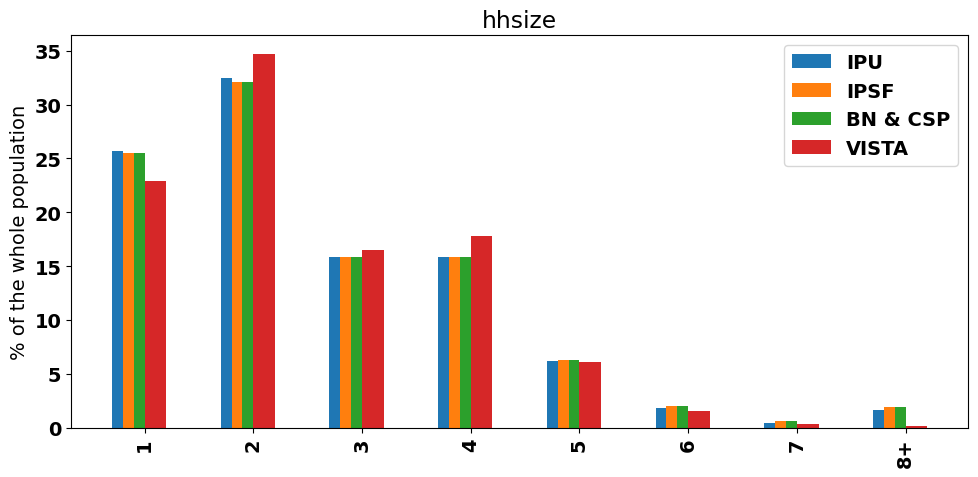

In [11]:
hold_dict_hh = {}
for att in atts_hh_labels:
    re_dict = plot_bar_syn(att=att, att_lab=atts_hh_labels, is_hh=True)
    hold_dict_hh[att] = re_dict

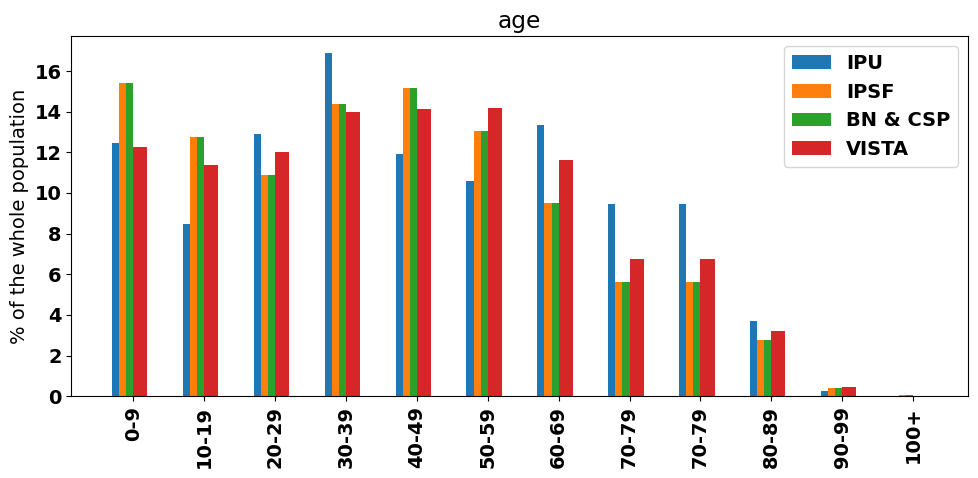

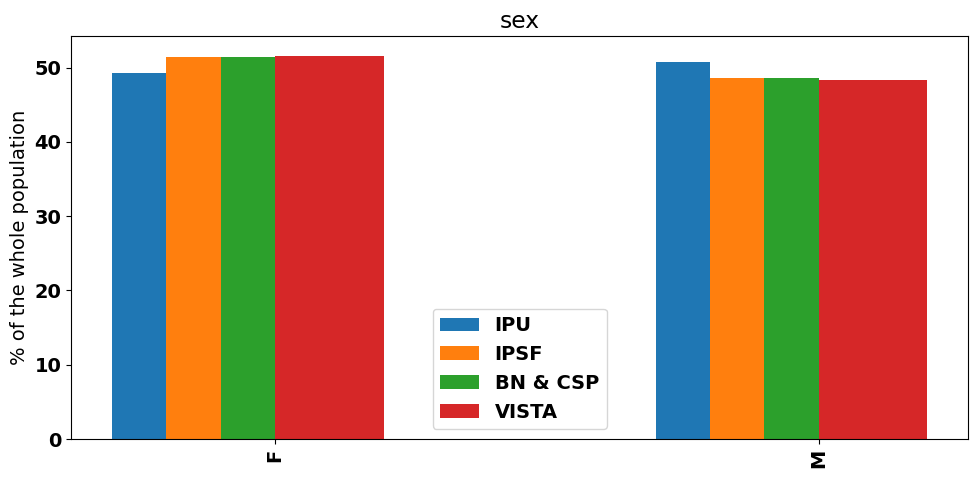

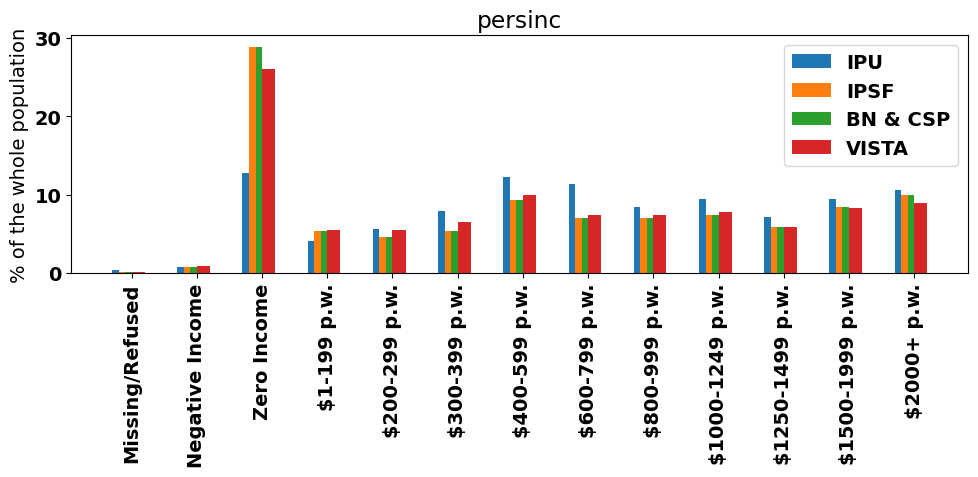

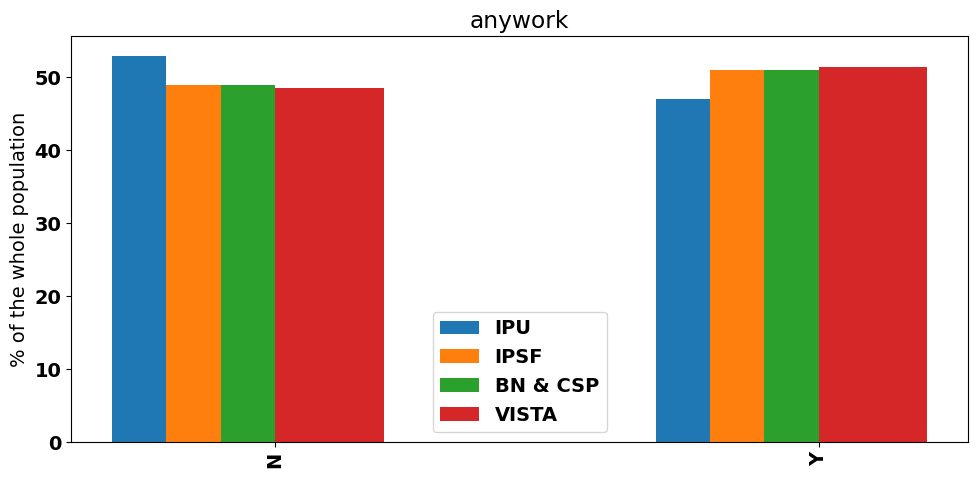

In [12]:
hold_dict_pp = {}
for att in atts_pp_labels:
    hold_dict_pp[att] = plot_bar_syn(att=att, att_lab=atts_pp_labels, is_hh=False)

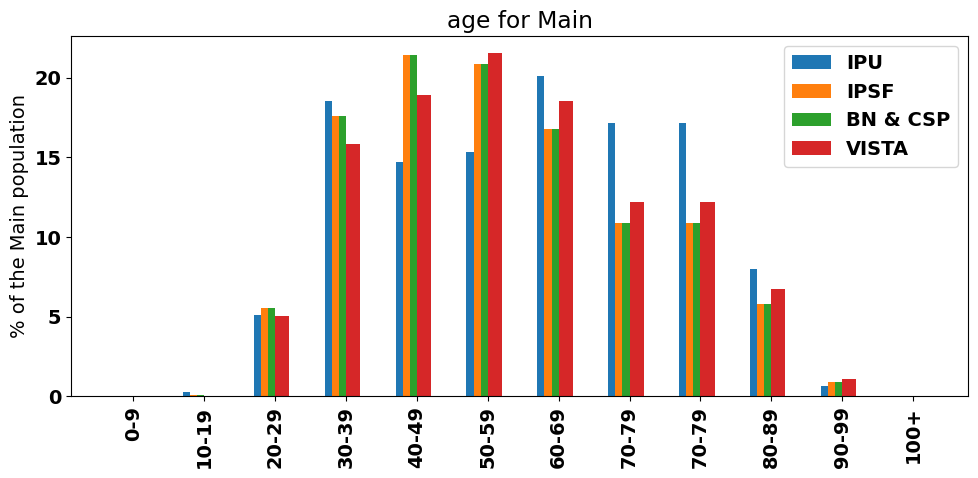

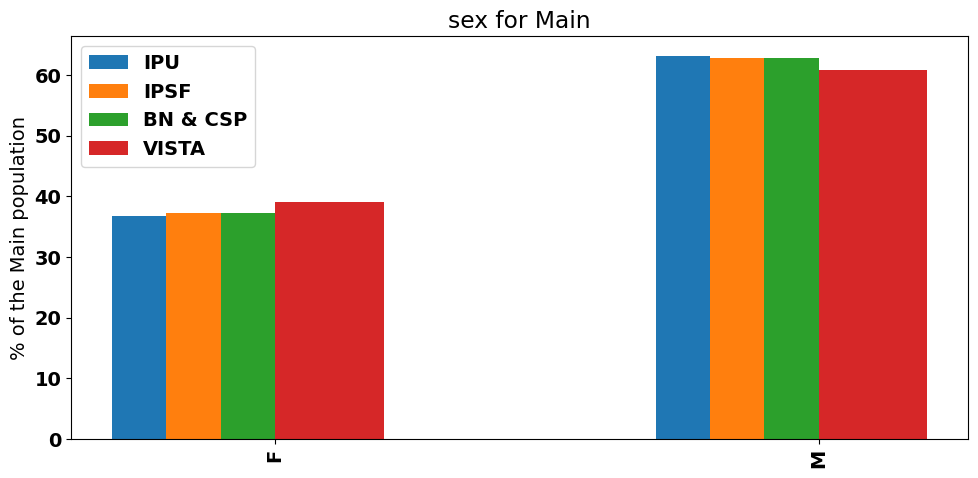

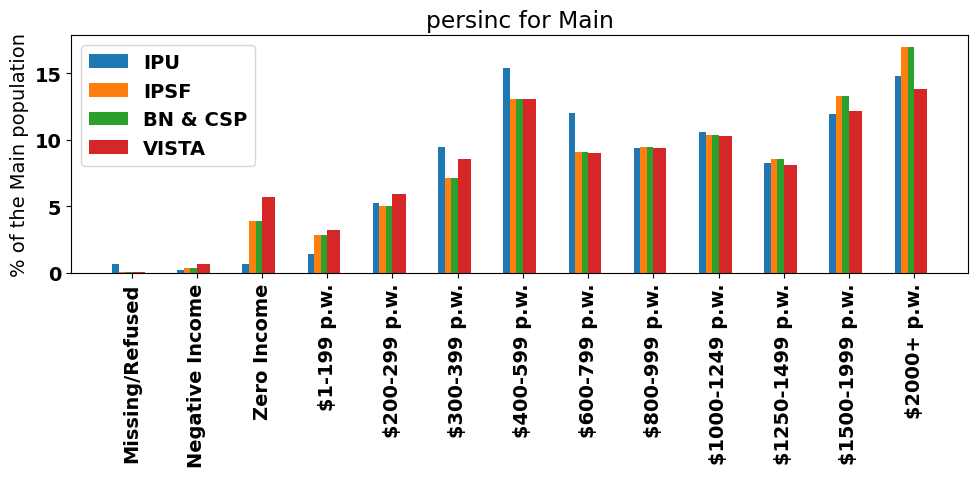

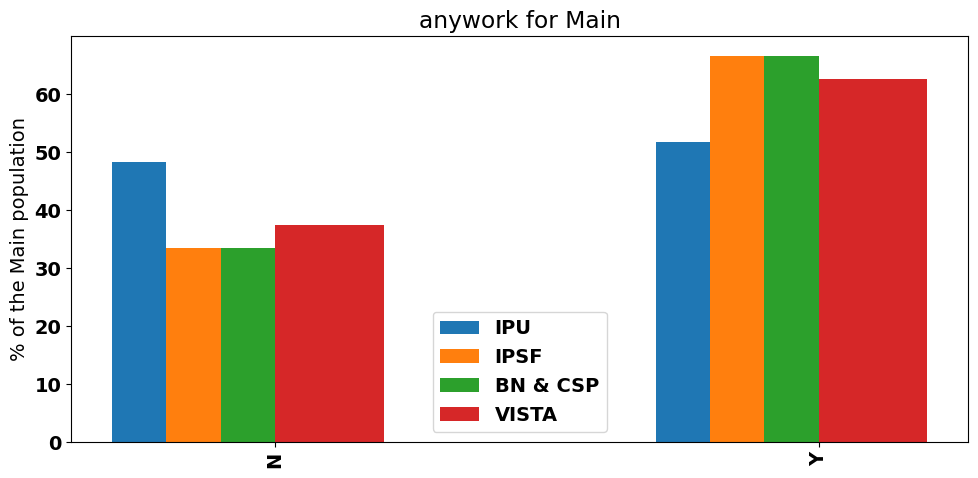

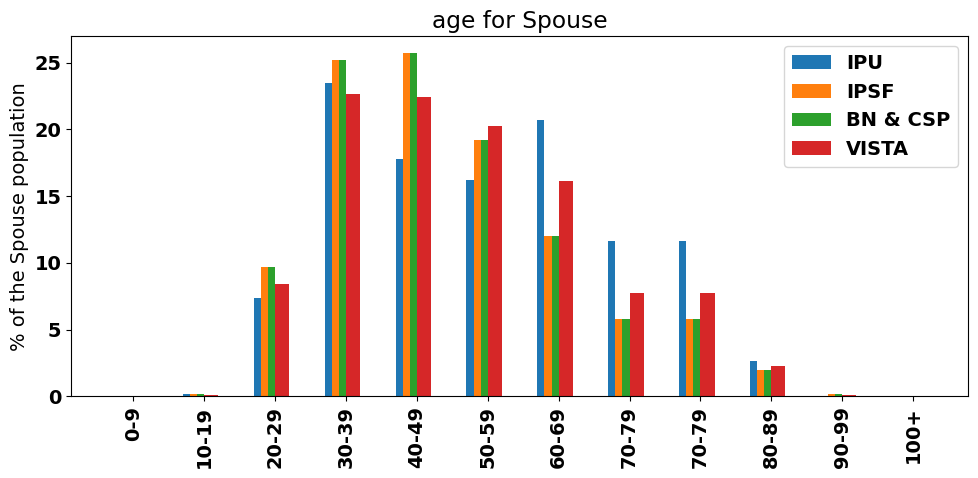

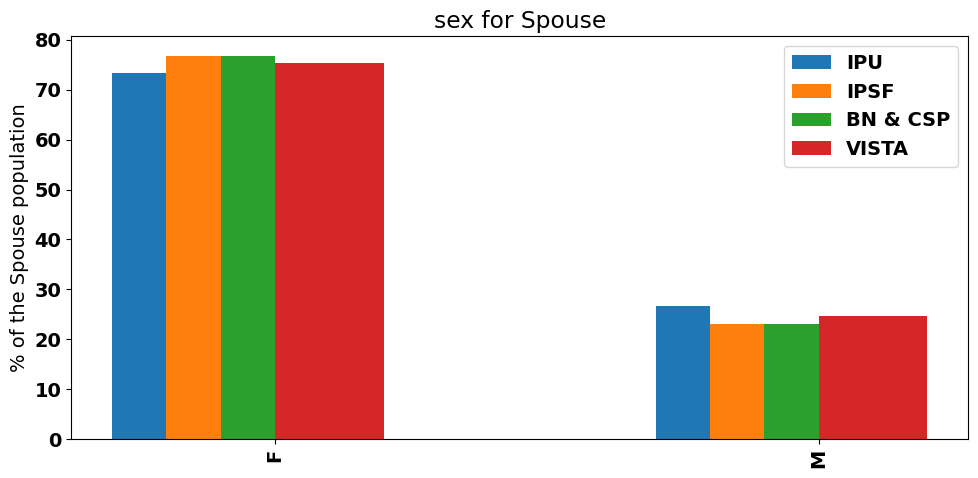

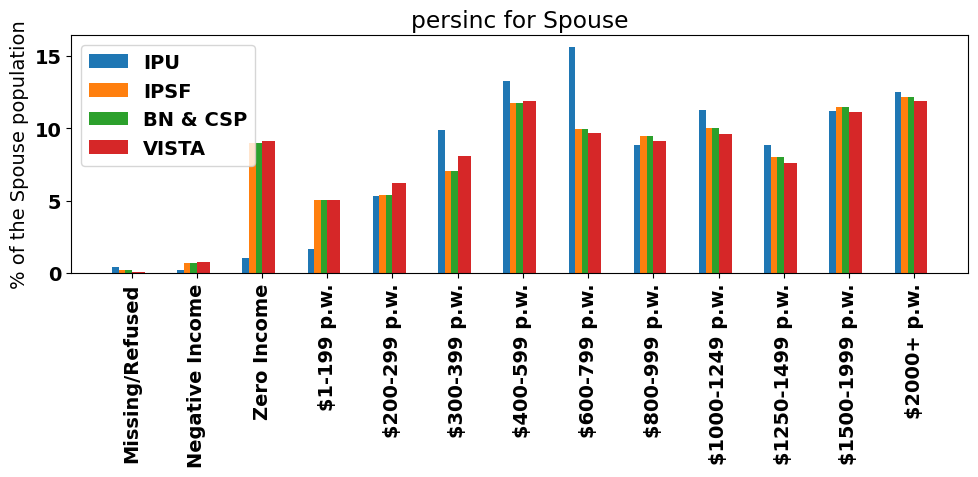

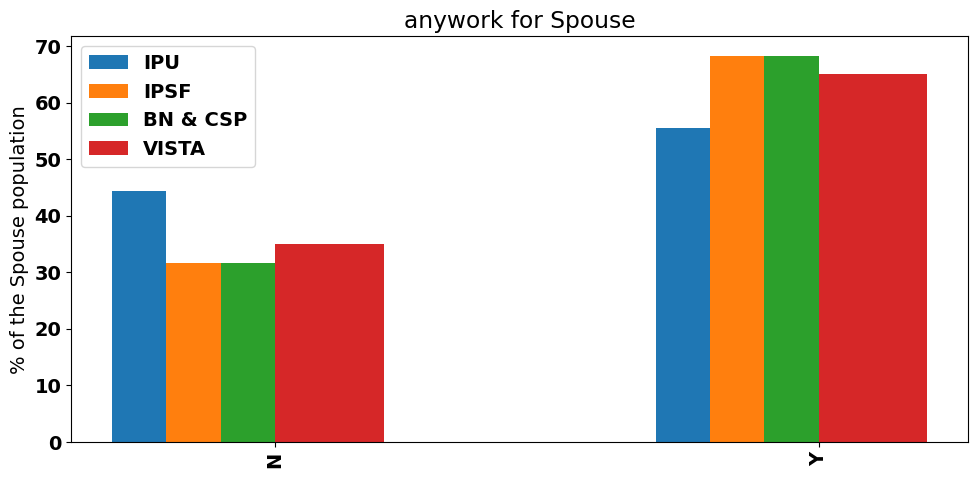

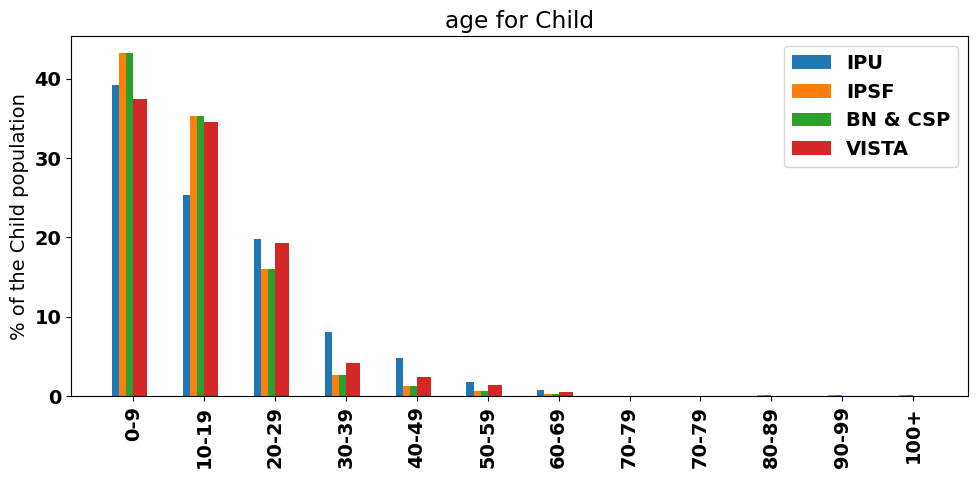

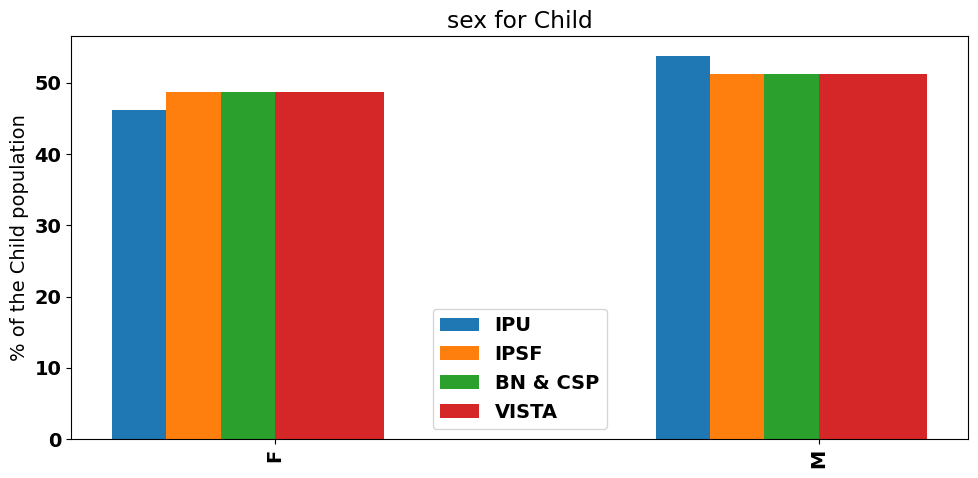

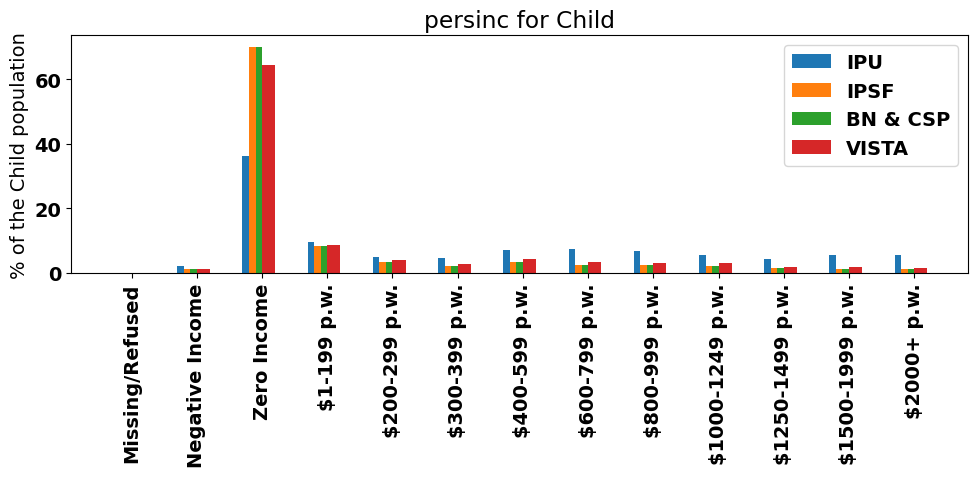

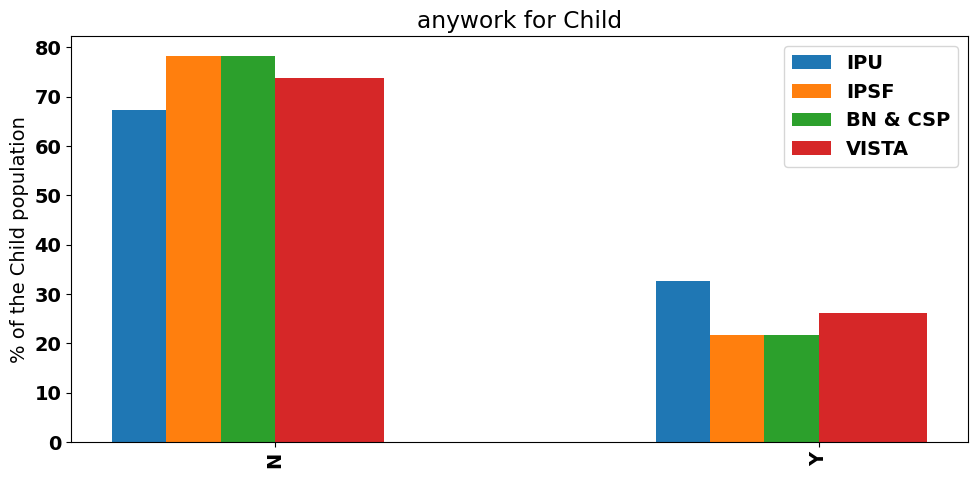

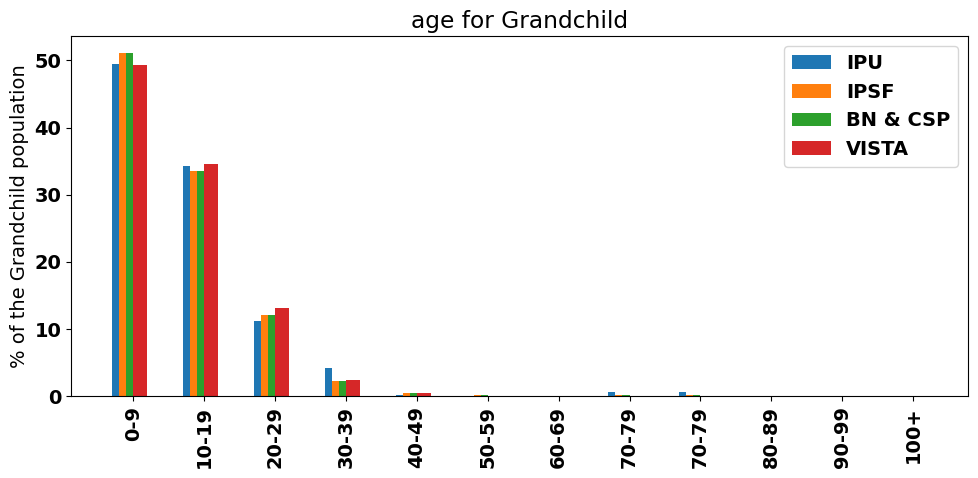

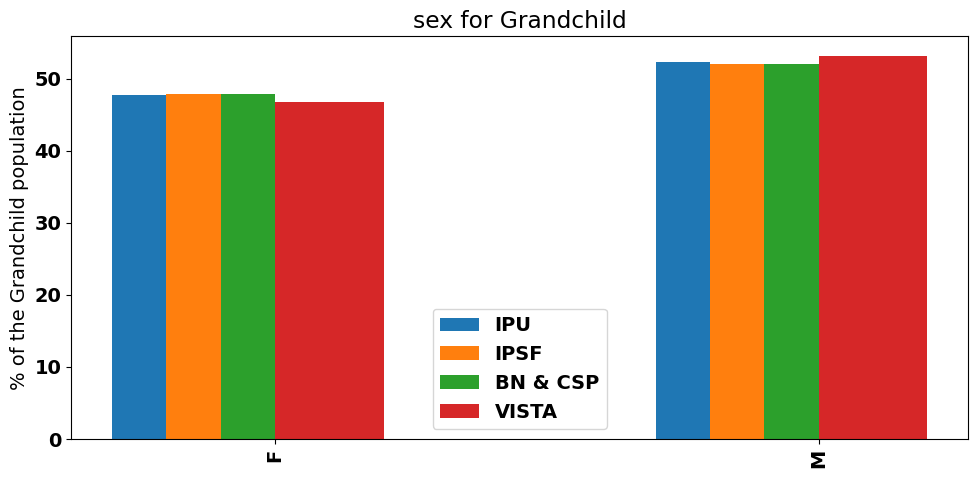

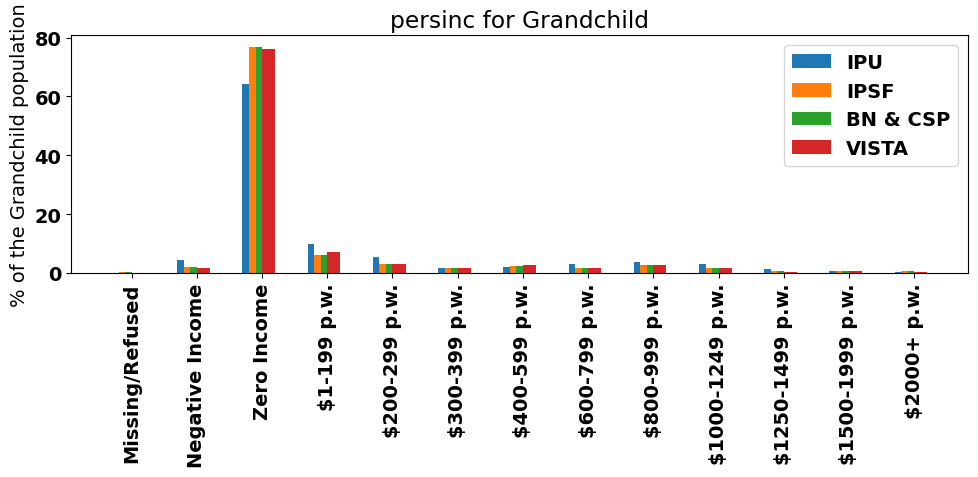

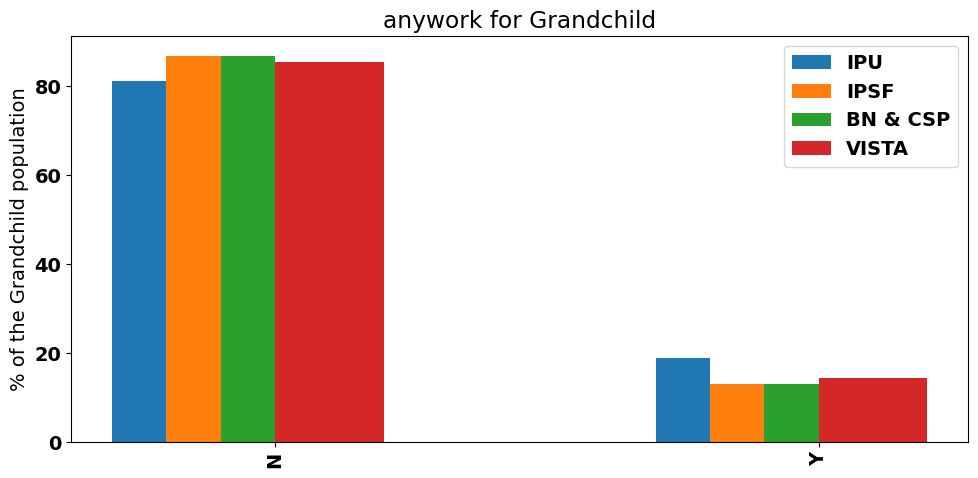

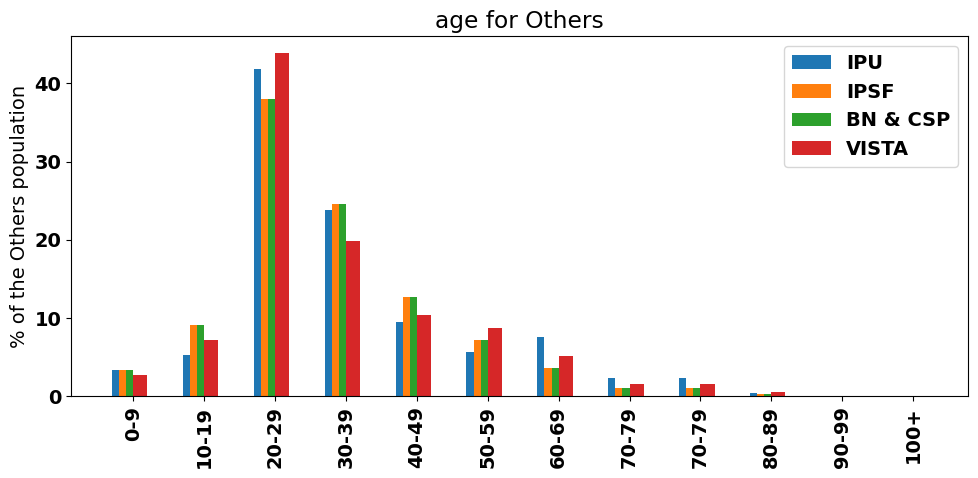

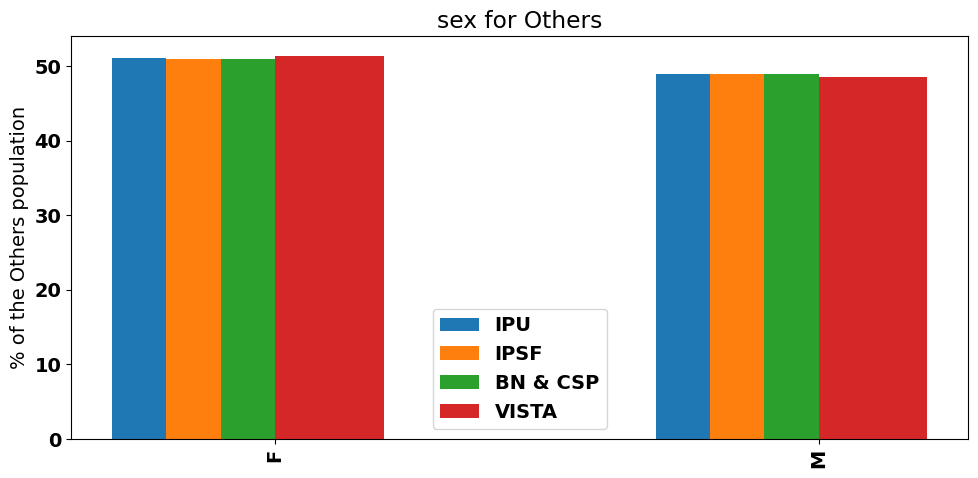

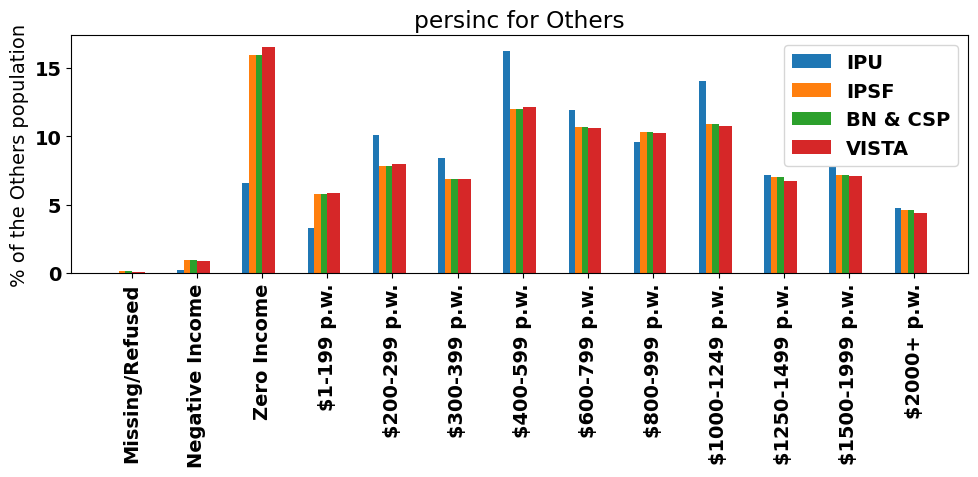

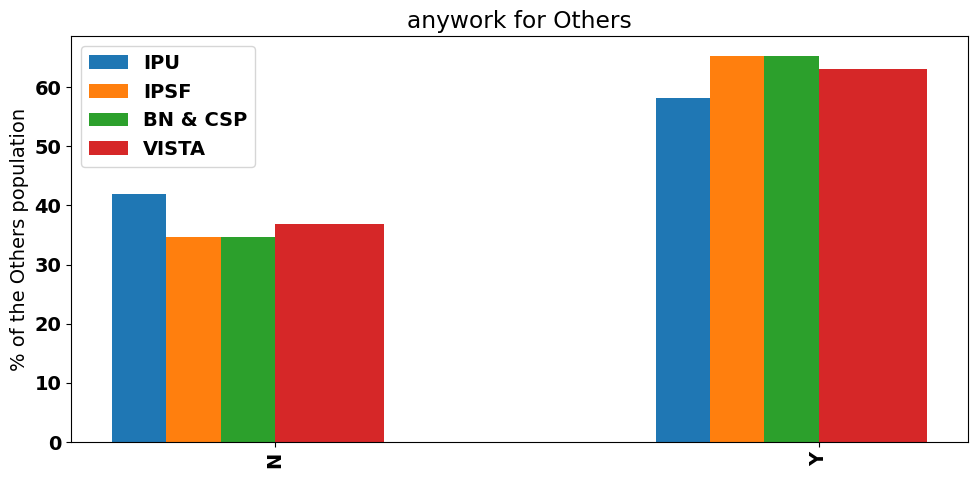

In [13]:
ls_rela = syn_pp_adjust["relationship"].unique()
hold_dict_rela = {}
for rela in ls_rela:
    for att in atts_pp_labels:
        re_dict = plot_bar_syn(att=att, rela=rela, att_lab=atts_pp_labels)
        hold_dict_rela[f"{rela}_{att}"] = re_dict

In [14]:
from scipy.spatial.distance import jensenshannon

In [15]:
def process_dict_data(dict_d):
    d_df = []
    ls_names = []
    for key, d in dict_d.items():
        score_ipu = jensenshannon(d["vista"], d["ipu"], base=2)
        score_adjust = jensenshannon(d["vista"], d["adjust"], base=2)
        score_noad = jensenshannon(d["vista"], d["simplebn"], base=2)
        d_df.append([score_adjust, score_ipu, score_noad])
        ls_names.append(key)

    cols_names = ["IPSF", "IPU", "BN_CSP"]
    df_all_scores = pd.DataFrame(d_df, index=ls_names, columns=cols_names)
    return df_all_scores

In [16]:
df_re_hh = process_dict_data(hold_dict_hh)
df_re_hh

,IPSF,IPU,BN_CSP
dwelltype,0.139867,0.150100,0.049081
owndwell,0.109930,0.105409,0.024035
hhinc,0.217153,0.219483,0.026797
totalvehs,0.052036,0.047846,0.046980
hhsize,0.090671,0.080617,0.053178


In [17]:
df_re_pp = process_dict_data(hold_dict_pp)
df_re_pp

,IPSF,IPU,BN_CSP
age,0.060415,0.091879,0.025107
sex,0.002074,0.020454,0.002029
persinc,0.040004,0.157433,0.009271
anywork,0.003127,0.037534,0.000347


In [18]:
df_re_all_pp = process_dict_data(hold_dict_rela)
df_re_all_pp

,IPSF,IPU,BN_CSP
Main_age,0.045602,0.109581,0.014701
Main_sex,0.016522,0.020435,0.001923
Main_persinc,0.062839,0.155791,0.014654
Main_anywork,0.035691,0.094070,0.005029
Spouse_age,0.078902,0.102696,0.034948
Spouse_sex,0.015383,0.019821,0.001344
Spouse_persinc,0.027926,0.206970,0.019028
Spouse_anywork,0.029995,0.081514,0.002544
Child_age,0.090167,0.113880,0.040707
Child_sex,0.000025,0.021755,0.000499


In [19]:
d_rela = []
for rela in ls_rela:
    sub_df_avg = df_re_all_pp[df_re_all_pp.index.str.contains(rela)].mean()
    d_rela.append(list(sub_df_avg))

df_by_rela = pd.DataFrame(d_rela, columns=df_re_all_pp.columns, index=ls_rela)
df_by_rela

,IPSF,IPU,BN_CSP
Main,0.040164,0.094969,0.009077
Spouse,0.038052,0.102750,0.014466
Child,0.047944,0.114543,0.016281
Grandchild,0.028365,0.069459,0.032030
Others,0.031899,0.074227,0.025282


In [20]:
def quick_f(df): 
    df["ISFP_to_IPU"] = (df["IPSF"] - df["IPU"])
    df["ISFP_to_BN_CSP"] = (df["IPSF"] - df["BN_CSP"])
    return df

fin_by_rela = quick_f(df_by_rela)
fin_re_all_pp = quick_f(df_re_all_pp)
fin_re_pp = quick_f(df_re_pp)
fin_re_hh = quick_f(df_re_hh)

In [21]:
df_re_all_pp.to_csv("./output/tables/samples_all.csv")
df_by_rela.to_csv("./output/tables/samples_rela.csv")
df_re_pp.to_csv("./output/tables/samples_atts.csv")
df_re_hh.to_csv("./output/tables/samples_hh_atts.csv")

In [22]:
# Final Rela score
df_by_rela.mean()

IPSF              0.037285
IPU               0.091190
BN_CSP            0.019427
ISFP_to_IPU      -0.053905
ISFP_to_BN_CSP    0.017857
dtype: float64

In [23]:
# Final PP score
df_re_pp.mean()

IPSF              0.026405
IPU               0.076825
BN_CSP            0.009189
ISFP_to_IPU      -0.050420
ISFP_to_BN_CSP    0.017216
dtype: float64

In [24]:
# Final PP score
df_re_hh.mean()

IPSF              0.121931
IPU               0.120691
BN_CSP            0.040014
ISFP_to_IPU       0.001241
ISFP_to_BN_CSP    0.081917
dtype: float64

In [25]:
fin_by_rela.round(3)

,IPSF,IPU,BN_CSP,ISFP_to_IPU,ISFP_to_BN_CSP
Main,0.040,0.095,0.009,-0.055,0.031
Spouse,0.038,0.103,0.014,-0.065,0.024
Child,0.048,0.115,0.016,-0.067,0.032
Grandchild,0.028,0.069,0.032,-0.041,-0.004
Others,0.032,0.074,0.025,-0.042,0.007


In [26]:
fin_re_pp["type"] = "Persons"
fin_re_pp.index.name = "att"
fin_re_hh["type"] = "Households"
fin_re_hh.index.name = "att"
fin_re_hh = fin_re_hh.reset_index().set_index(["type", "att"])
fin_re_pp = fin_re_pp.reset_index().set_index(["type", "att"])
fin_fin = pd.concat([fin_re_hh, fin_re_pp])
fin_fin.round(3)

IPSF    IPU  BN_CSP  ISFP_to_IPU  ISFP_to_BN_CSP
type       att                                                         
Households dwelltype  0.140  0.150   0.049       -0.010           0.091
           owndwell   0.110  0.105   0.024        0.005           0.086
           hhinc      0.217  0.219   0.027       -0.002           0.190
           totalvehs  0.052  0.048   0.047        0.004           0.005
           hhsize     0.091  0.081   0.053        0.010           0.037
Persons    age        0.060  0.092   0.025       -0.031           0.035
           sex        0.002  0.020   0.002       -0.018           0.000
           persinc    0.040  0.157   0.009       -0.117           0.031
           anywork    0.003  0.038   0.000       -0.034           0.003